# Preprocessing
First, let's focus on correctly preprocessing the data. Probably this is the key for a successful classification later on.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle

In [2]:
path = "D:/GitHub/Machine-Learning/Kaggle/"

zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [3]:
df_train.head()

,ID_sample,OXACILINA,AMIKACINA,AMOXI/CLAV,CIPROFLOXACINO,CLINDAMICINA,ERITROMICINA,LEVOFLOXACINO,PENICILINA,TOBRAMICINA,intensity,coord_mz
ID,,,,,,,,,,,,
0,38,0,0.0,0,0,0,0,NaN,1,0.0,"[2504.0, 2587.0, 2566.0, 2529.0, 2440.0, 2345....","[1999.8537952394886, 2000.270974900746, 2000.6..."
1,38,0,0.0,0,0,0,0,NaN,1,0.0,"[2016.0, 2046.0, 2020.0, 1975.0, 1960.0, 1948....","[1999.8537952394886, 2000.270974900746, 2000.6..."
2,42,0,NaN,0,0,0,0,0.0,1,NaN,"[5482.0, 5433.0, 5446.0, 5395.0, 5295.0, 5154....","[1998.4098728475867, 1998.827574358552, 1999.2..."
3,42,0,NaN,0,0,0,0,0.0,1,NaN,"[5179.0, 5103.0, 5080.0, 4958.0, 4930.0, 4836....","[1998.4098728475867, 1998.827574358552, 1999.2..."
4,50,0,NaN,0,0,0,0,0.0,0,NaN,"[2731.0, 2695.0, 2638.0, 2641.0, 2640.0, 2518....","[1999.9947504661932, 2000.4119868539617, 2000...."


In [22]:
print(df_train)

    ID_sample  OXACILINA  AMIKACINA  AMOXI/CLAV  CIPROFLOXACINO  CLINDAMICINA  \
ID                                                                              
0          38          0        0.0           0               0             0   
1          38          0        0.0           0               0             0   
2          42          0        NaN           0               0             0   
3          42          0        NaN           0               0             0   
4          50          0        NaN           0               0             0   
..        ...        ...        ...         ...             ...           ...   
511      1984          1        0.0           1               1             0   
512      1984          1        0.0           1               1             0   
513      1984          1        0.0           1               1             0   
514      1996          1        0.0           1               1             1   
515      1996          1    

As we can see, the data contains different columns:
* **ID**: Just the basic index per row
* **ID_sample**: the ID of the physical sample this is coming from. We should think about how to use different experimental results coming from the same sample. For the moment being, let's just treat them as different samples.
* **Different antibiotics**: data of whether the sample is resistant of not to 9 different antibiotics. Our goal is to predict separately these resistances (one binary classifier for each antibiotic).
* **MZ coordinate**: mass spectrometry is defined over the so-called m/z spectra. Therefore, this constitutes the X axis of the plot.
* **Intensity**: Intensity of the spectra at each point (Y values).

Literature:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6088204/

Basically, it seems that MALDI TOF MS is routinely used for sample identification. Also, it is used for susceptibility testing (antibiotic resistance classification), mainly using the peaks of the spectra.

### Preprocessing of the data


#### Eliminate NaN values
First, we should remove all the NaN values present in the data. We have two options, either replace by the most frequent value, or conversely, not use those samples to train the classifiers for those antibiotics. This could be done creating an index (a kind of mask) of which samples are to be used for each classifier. I will try the second approach.

#### Preprocessing the spectra
Also, we should preprocess the spectra. We have several options:
* Try to just obtain the peaks and their associated mz value.
* Put all spectra in the same mz scale, and use the full spectra as a set of features (each spectral point, one feature). To avoid noise or interpolation errors, we could "bin" the spectra in small ranges of mz coordinate. That is, the bin 2000-2010 mz contains the highest value in that range of that spectra.

For the moment being, let's try the second one.

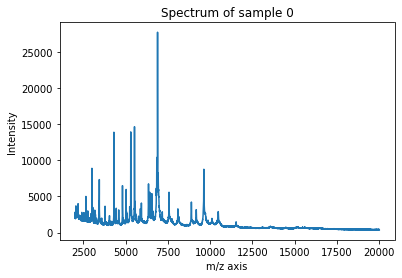

In [4]:
# Let's plot one original spectra
idx = 0
y_axis = df_train.loc[idx,'intensity']
x_axis = df_train.loc[idx,'coord_mz']

plt.plot(x_axis,y_axis)
plt.xlabel('m/z axis')
plt.ylabel('Intensity')
plt.title('Spectrum of sample '+str(idx))
plt.show()

We have a problem: each data comes as a (x,y) pair. A mz coordinate with an associated intensity. The classifiers we have seen so far work in a different way: for each feature, there is a value. The classifier/regressor learns how to combine the different values of the features to give a prediction. Therefore, having a single feature with (mz,intensity) pairs does not seem an option. For that reason, let's try to create "bins" in which to segment the spectra and provide a unified feature set (consisting of the peaks at the different mz ranges).

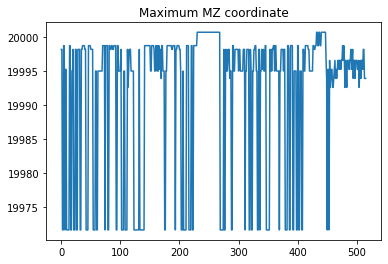

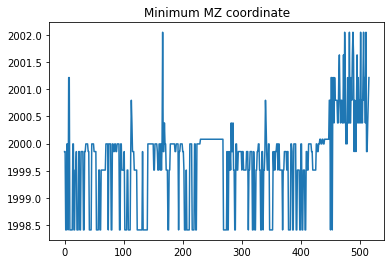

In [95]:
bin_size = 20 # 20 seems big enough to avoid small mz differences, but not too coarse
# Nevertheless, it is a parameter that we could tune to get better results

# First, let's find the maximum mz coordinates, in order to define all ranges appropiately
mins = [np.min(mz[0]) for mz in df_train[['coord_mz']].values ]
maxs = [np.max(mz[0]) for mz in df_train[['coord_mz']].values ]

plt.plot(maxs)
plt.title('Maximum MZ coordinate')
plt.show()
plt.plot(mins)
plt.title('Minimum MZ coordinate')
plt.show()
M = np.ceil(np.max(maxs)).astype(int)
# In order to always be coherent with the ranges, let's always start in 0.
m = 0

In [96]:
# Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
range_min = []; range_max = []; range_label = [];
for mz in range(m,M,bin_size):
#     print('Mz: ',mz)
    range_min.append(mz)
    range_max.append(mz+bin_size)
    range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))

# for  # this sould be done in a loop for all samples.
idx = 0 # Let's first do it for just sample 0
intensity = df_train[['intensity']].loc[idx].values[0]
mzcoord   = df_train[['coord_mz']].loc[idx].values[0]
idx_data_in_bins = np.zeros((len(range_min),1))
for i,mz in enumerate(range_min):
    intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
    if len(intensity_range) > 0 :
        idx_data_in_bins[i] = np.max(intensity_range)
    else: # if those mz coordinates are not in that spectrum
        idx_data_in_bins[i] = 0    

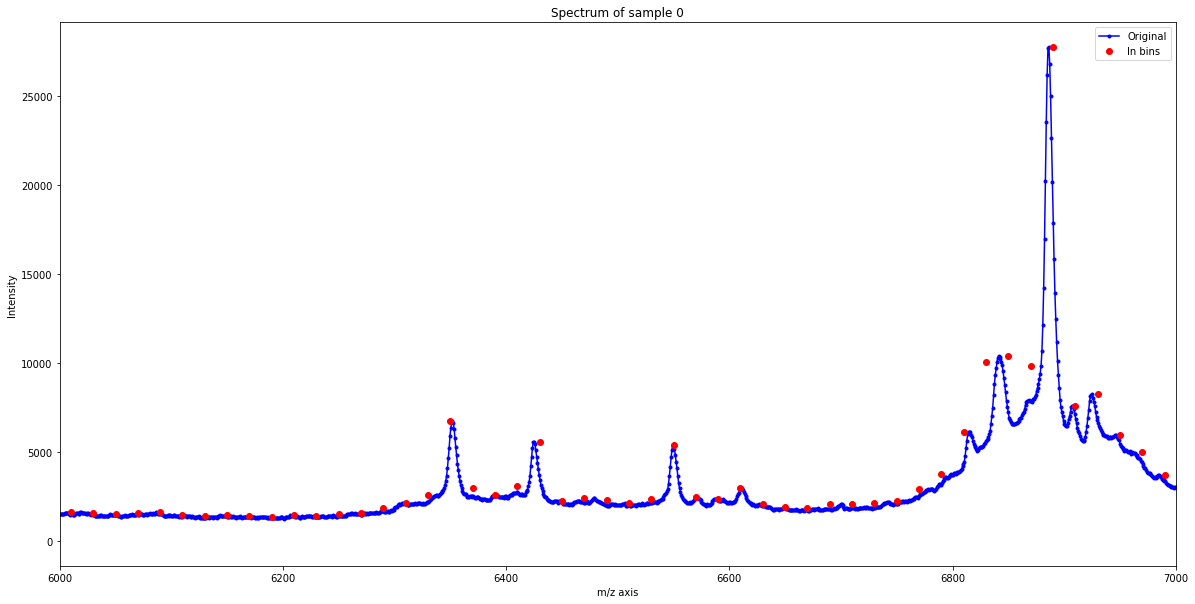

In [99]:
plt.figure(figsize=(20,10))
plt.plot(x_axis,y_axis,'b.-',label='Original')
plt.plot(range_label,idx_data_in_bins,'ro',label='In bins')
plt.legend()
plt.xlabel('m/z axis')
plt.ylabel('Intensity')
plt.title('Spectrum of sample '+str(idx))
plt.xlim(2000,12000)
plt.xlim(6000,7000)
plt.show()

As we can see, the aproximation is quite good, and in this way we have an "standard feature set". Now, let's generalize this to a function to which we can pass different dataframes (namely, test and train dataframes).

In [128]:
def spectrum_in_bins(df,m,M,bin_size):
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_label = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))


    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum
                idx_data_in_bins[0,i] = 0   

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        
        
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_label, index = df.index.values)
    return new_df

In [129]:
new_df = spectrum_in_bins(df_train,2000,20000,20)

In [130]:
new_df.head()

,2010,2030,2050,2070,2090,2110,2130,2150,2170,2190,...,19810,19830,19850,19870,19890,19910,19930,19950,19970,19990
0,0.102160,0.081101,0.133064,0.099744,0.124986,0.103458,0.088457,0.126032,0.088349,0.144063,...,0.015073,0.015470,0.015109,0.015254,0.015254,0.014965,0.015614,0.015254,0.015759,0.015795
1,0.107689,0.090115,0.171582,0.115868,0.142416,0.118673,0.101145,0.161486,0.100257,0.181211,...,0.013975,0.013788,0.013601,0.013555,0.014022,0.013882,0.013742,0.013601,0.013321,0.013788
2,0.167808,0.121714,0.212769,0.154401,0.188590,0.159116,0.122610,0.166913,0.124006,0.222041,...,0.013380,0.013328,0.013301,0.013855,0.013354,0.013249,0.013012,0.013117,0.013512,0.000000
3,0.109877,0.094813,0.194793,0.120624,0.142626,0.125808,0.096642,0.192983,0.105654,0.204653,...,0.007296,0.007240,0.007296,0.007541,0.007485,0.007485,0.007485,0.007409,0.007391,0.000000
4,0.097300,0.078888,0.117169,0.097951,0.108490,0.111745,0.084374,0.103624,0.079446,0.126716,...,0.007780,0.007625,0.007966,0.007935,0.007811,0.007780,0.008214,0.007594,0.007811,0.008183


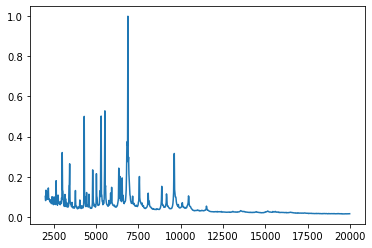

In [131]:
plt.plot(new_df.iloc[idx,:])

### Data split
Separate data in data and targets, as well as in train, validation and test data.

In [165]:
from sklearn.model_selection import train_test_split

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train, validation and test set
# ¿¿ Should we eliminate the test in the future ??
# For the moment, I prefer to have test_train here and not in Kaggle, a priori
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=42) # split the data
data_train, data_valid, targets_train, targets_valid = train_test_split(data_train, targets_train, test_size = 0.2, random_state = 0)
# now we have data_train, data_valid and data_test_train, with their corresponding targets
print('Training points: '+str(len(data_train))+' , validation samples: '+str(len(data_valid))+ ' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples
m = 2000; M = 20000; bin_size = 50; 
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins(data_test_train,m,M,bin_size)
spectrum_valid = spectrum_in_bins(data_valid,m,M,bin_size)
# these spectrum_... are our X for training

Training points: 329 , validation samples: 83 and test_train samples: 104


In [166]:
data_train

,intensity,coord_mz
ID,,
216,"[1752.0, 1772.0, 1757.0, 1799.0, 1792.0, 1726....","[1998.4098728475867, 1998.827574358552, 1999.2..."
397,"[953.0, 1019.0, 1054.0, 1076.0, 1035.0, 1044.0...","[1999.5129921896278, 1999.9303316643989, 2000...."
279,"[1543.0, 1577.0, 1571.0, 1569.0, 1562.0, 1516....","[1999.5129921896278, 1999.9303316643989, 2000...."
59,"[3343.0, 3298.0, 3287.0, 3255.0, 3203.0, 3219....","[1999.5129921896278, 1999.9303316643989, 2000...."
438,"[2502.0, 2578.0, 2601.0, 2612.0, 2532.0, 2439....","[1999.9947504661932, 2000.4119868539617, 2000...."
...,...,...
309,"[1993.0, 2084.0, 2070.0, 2051.0, 2043.0, 2066....","[1999.8537952394886, 2000.270974900746, 2000.6..."
365,"[1420.0, 1424.0, 1460.0, 1431.0, 1375.0, 1347....","[1999.5129921896278, 1999.9303316643989, 2000...."
199,"[3050.0, 3033.0, 3011.0, 2975.0, 2950.0, 2907....","[1999.9947504661932, 2000.4119868539617, 2000...."


In [167]:
spectrum_train

,2025,2075,2125,2175,2225,2275,2325,2375,2425,2475,...,19525,19575,19625,19675,19725,19775,19825,19875,19925,19975
216,0.070084,0.075983,0.090956,0.079991,0.053637,0.048443,0.051617,0.047161,0.064313,0.046360,...,0.013914,0.014139,0.014107,0.014363,0.014139,0.013978,0.014043,0.013754,0.013978,0.013369
397,0.085501,0.071274,0.076784,0.079085,0.070019,0.054537,0.052863,0.053560,0.058581,0.055652,...,0.025176,0.025037,0.024967,0.025176,0.024827,0.024130,0.025106,0.025525,0.024758,0.025316
279,0.073325,0.079599,0.084443,0.087057,0.063184,0.054053,0.050045,0.044853,0.062626,0.044818,...,0.013034,0.012964,0.012964,0.013034,0.013069,0.013139,0.012686,0.012895,0.012860,0.012895
59,0.124536,0.122410,0.128079,0.132785,0.097831,0.074869,0.074926,0.072261,0.098398,0.075861,...,0.019872,0.019816,0.020213,0.019731,0.020043,0.020043,0.019617,0.019759,0.019929,0.019759
438,0.077977,0.090676,0.090969,0.104059,0.070466,0.058061,0.059529,0.055687,0.079445,0.056054,...,0.011720,0.011695,0.011475,0.011353,0.011353,0.011304,0.011353,0.011304,0.011255,0.011524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.056513,0.087523,0.077443,0.090868,0.050065,0.048718,0.043401,0.039527,0.062238,0.041067,...,0.009407,0.008902,0.009046,0.009166,0.009286,0.009070,0.009022,0.008950,0.009046,0.009070
365,0.094489,0.076904,0.103407,0.095691,0.071643,0.058317,0.056212,0.056212,0.066082,0.056363,...,0.022745,0.022094,0.023898,0.022645,0.022695,0.022495,0.021844,0.022144,0.022545,0.022094
199,0.080417,0.076688,0.097421,0.098657,0.056674,0.048565,0.050115,0.044634,0.060807,0.048205,...,0.014623,0.014511,0.014489,0.014623,0.014533,0.014825,0.014691,0.014556,0.014646,0.014960
192,0.118889,0.115341,0.158122,0.155993,0.091949,0.088032,0.073298,0.063476,0.087776,0.072077,...,0.009822,0.009680,0.009595,0.009766,0.010106,0.009794,0.009482,0.009737,0.009396,0.009964


In [160]:
targets_test_train

,OXACILINA,AMIKACINA,AMOXI/CLAV,CIPROFLOXACINO,CLINDAMICINA,ERITROMICINA,LEVOFLOXACINO,PENICILINA,TOBRAMICINA
ID,,,,,,,,,
304,1,1.0,1,1,1,1,1.0,1,1.0
500,0,0.0,0,0,1,1,0.0,1,0.0
441,1,0.0,1,0,0,0,0.0,1,0.0
153,0,0.0,0,0,0,0,0.0,1,0.0
502,1,1.0,1,1,1,1,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...
167,0,1.0,0,0,1,1,0.0,1,1.0
275,1,1.0,1,1,0,0,1.0,1,1.0
508,0,0.0,0,0,0,0,0.0,1,0.0


## Process true set data

In [161]:
df_test.head()

,ID_sample,intensity,coord_mz
ID,,,
0,3383,"[1674.0, 1737.0, 1746.0, 1767.0, 1673.0, 1631....","[2000.0809408379346, 2000.4988169824649, 2000...."
1,3383,"[2841.0, 2777.0, 2747.0, 2745.0, 2697.0, 2672....","[2000.0809408379346, 2000.4988169824649, 2000...."
2,2048,"[1075.0, 1040.0, 1043.0, 1015.0, 1020.0, 1057....","[1999.5129921896278, 1999.9303316643989, 2000...."
3,4534,"[2473.0, 2415.0, 2373.0, 2288.0, 2330.0, 2317....","[2000.0809408379346, 2000.4988169824649, 2000...."
4,4534,"[201.0, 188.0, 208.0, 195.0, 187.0, 180.0, 171...","[2000.0809408379346, 2000.4988169824649, 2000...."


In [162]:
# For test we select a unique spectra per sample
df_unique_test = df_test.drop_duplicates(subset='ID_sample')
data_test = df_unique_test.iloc[:,-2:]
spectrum_test = spectrum_in_bins(data_test,m,M,bin_size)

In [163]:
spectrum_test

,2005,2015,2025,2035,2045,2055,2065,2075,2085,2095,...,19905,19915,19925,19935,19945,19955,19965,19975,19985,19995
0,0.061557,0.080334,0.054729,0.055391,0.059467,0.072392,0.069883,0.062567,0.075631,0.069639,...,0.014318,0.014945,0.014562,0.014736,0.014562,0.014875,0.014283,0.014353,0.014945,0.015050
2,0.032963,0.034581,0.028587,0.029940,0.030841,0.050041,0.039248,0.030974,0.040600,0.039301,...,0.007319,0.007107,0.007690,0.007001,0.007319,0.007399,0.007637,0.007611,0.007293,0.007293
3,0.071172,0.102138,0.061099,0.064178,0.063516,0.085043,0.071690,0.065531,0.089447,0.083978,...,0.015426,0.015829,0.015455,0.015598,0.015886,0.015426,0.016260,0.015886,0.015944,0.015829
5,0.060233,0.063907,0.051301,0.053222,0.054469,0.080828,0.060537,0.053593,0.061817,0.060267,...,0.011056,0.011056,0.010618,0.010719,0.010382,0.010382,0.010449,0.010348,0.000000,0.000000
7,0.123245,0.126281,0.100901,0.110736,0.115434,0.222640,0.147199,0.118574,0.160771,0.155970,...,0.013962,0.013754,0.014118,0.013884,0.014014,0.014196,0.013651,0.013858,0.013962,0.013962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.080427,0.086611,0.074688,0.075329,0.079257,0.117200,0.104858,0.078588,0.100540,0.102546,...,0.010475,0.010753,0.010447,0.010586,0.010586,0.010614,0.011004,0.010586,0.011283,0.010670
211,0.031531,0.032462,0.029886,0.031314,0.033300,0.041152,0.038793,0.033021,0.040904,0.041121,...,0.011700,0.011545,0.011793,0.011483,0.011607,0.011576,0.011731,0.011576,0.011421,0.011328
213,0.051041,0.051586,0.043510,0.047548,0.047820,0.069598,0.059934,0.049090,0.063518,0.062701,...,0.012567,0.013248,0.012976,0.012749,0.013430,0.012749,0.012976,0.013339,0.013475,0.013384
215,0.182542,0.156484,0.137681,0.140468,0.159404,0.205415,0.166217,0.155422,0.198735,0.197850,...,0.023935,0.022962,0.023183,0.023271,0.023006,0.023979,0.022873,0.022254,0.000000,0.000000


As a first trial, let's try a RF

In [169]:
from sklearn.ensemble import RandomForestClassifier 
RF = RandomForestClassifier(n_estimators = 70, max_depth = 3)
RF.fit(spectrum_train.values,targets_train[['OXACILINA']].to_numpy().reshape(-1,))

acc_train = RF.score(spectrum_train,targets_train[['OXACILINA']].to_numpy().reshape(-1,))
acc_valid = RF.score(spectrum_valid,targets_valid[['OXACILINA']].to_numpy().reshape(-1,))
print('Train accuracy is %.4f and validation accuracy is %.4f' %(acc_train,acc_valid))


Train accuracy is 0.7477 and validation accuracy is 0.5783
